In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params
from GRF_perturbations.Modules.GRF_generation import get_Fourier_phase,get_k_grid

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [5]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

# Spectra for two different scales

In [6]:
'''Anomalies_images=np.zeros((10000,100,100))
Anomalies_spectra=np.zeros((10000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,2]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(10000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,False,noise_seed)
    Anomalies_images[i]=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft(Anomalies_images[i]))**2'''

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:14<00:00, 26.73it/s]


In [7]:
'''Anomalies_images_4=np.zeros((10000,100,100))
Anomalies_spectra_4=np.zeros((10000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,4]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(10000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,False,noise_seed)
    Anomalies_images_4[i]=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra_4[i]=np.abs(np.fft.fft(Anomalies_images_4[i]))**2'''

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:14<00:00, 26.68it/s]


In [9]:
#np.savez('./data/Anomalies_example',Anomalies_images=Anomalies_images,Anomalies_spectra=Anomalies_spectra,Anomalies_images_4=Anomalies_images_4,Anomalies_spectra_4=Anomalies_spectra_4)

In [268]:
q=np.load('./data/Anomalies_example.npz')
Anomalies_images=q['Anomalies_images']
Anomalies_spectra=q['Anomalies_spectra']
Anomalies_images_4=q['Anomalies_images_4']
Anomalies_spectra_4=q['Anomalies_spectra_4']

## degrees of freedom from real Fourier properties

In [384]:
Spectral_dof=2*np.ones((Observation_conditions.pixel_number,Observation_conditions.pixel_number))
Spectral_dof[:,0]=1
Spectral_dof[:,50]=1
#Spectral_dof[50,99]=1

In [383]:
np.where(np.abs(spectra[:,:,99].imag)<1e-7)[1]

array([89, 93, 33])

Correct for the places where we have no variance in imaginary part

In [269]:
#Anomalies_spectra/=Spectral_dof
#Anomalies_spectra_4/=Spectral_dof

## Independence of real and imaginary parts

In [255]:
import scipy as sc

In [256]:
def corr_matrix(tensor1,tensor2):
    corrs=np.zeros((tensor1.shape[-2],tensor1.shape[-1]))
    pvals=np.zeros((tensor1.shape[-2],tensor1.shape[-1]))
    
    for i in tqdm(range(tensor1.shape[-2])):
        for j in range(tensor1.shape[-1]):
            res=sc.stats.pearsonr(tensor1[:,i,j],tensor2[:,i,j])
            corrs[i,j]=res[0]
            pvals[i,j]=res[1]
            
    return corrs,pvals

spectra=np.fft.fft(Anomalies_images)

In [257]:
Rs,pvals=corr_matrix(spectra.real,spectra.imag)

  0%|                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.05it/s]


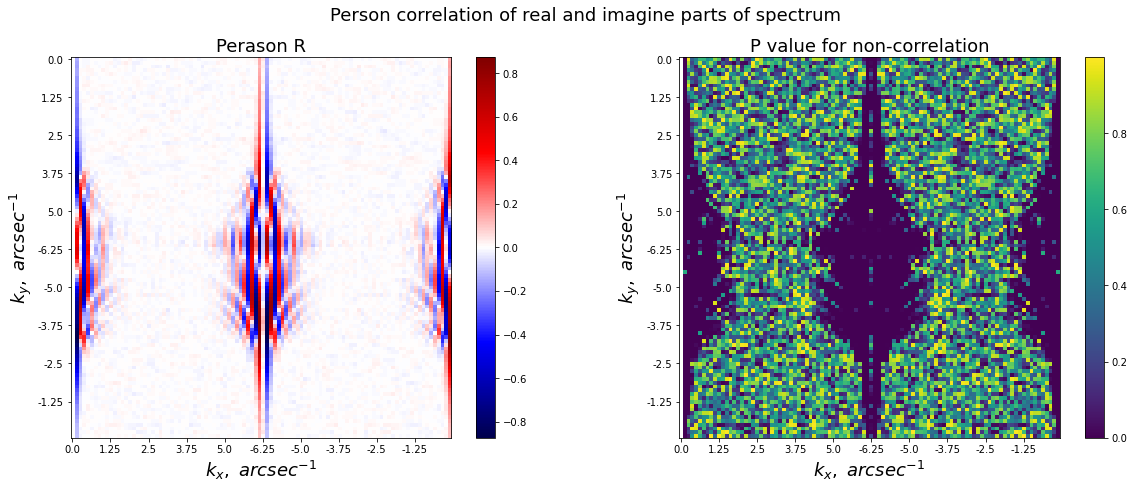

In [258]:
k_vector=np.fft.fftfreq(100,0.08)
fig,ax=plt.subplots(1,2,figsize=(20,7))

im=ax[0].imshow(Rs,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title('Perason R',fontsize=FS)
fig.colorbar(im,ax=ax[0])

im=ax[1].imshow(pvals)
ax[1].set_title('P value for non-correlation',fontsize=FS)
fig.colorbar(im,ax=ax[1])

for i in range(2):
    ax[i].set_yticks(np.arange(0,len(k_vector),10))
    ax[i].set_xticks(np.arange(0,len(k_vector),10))
    ax[i].set_yticklabels(k_vector[::10])
    ax[i].set_xticklabels(k_vector[::10])
    ax[i].set_ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)
    ax[i].set_xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
    
    
fig.suptitle('Person correlation of real and imagine parts of spectrum',fontsize=FS)
plt.show()

# Distribution of spectrum over phase

In [332]:
scale_estimates=Anomalies_spectra.mean(axis=0)
scale_estimates_4=Anomalies_spectra_4.mean(axis=0)

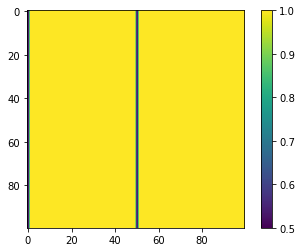

In [170]:
plt.imshow(Spectral_dof/2)
plt.colorbar()

## Original gamma distributions

Text(0, 0.5, 'Number density')

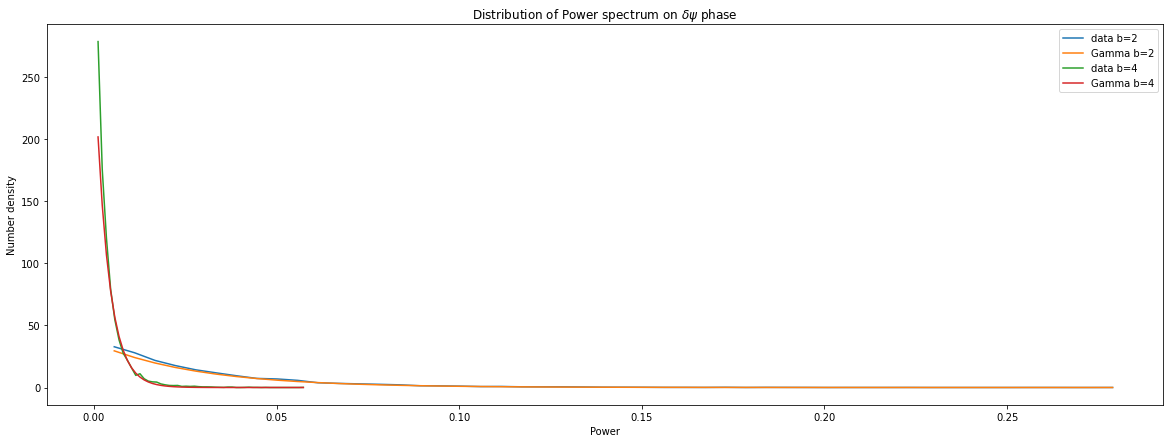

In [363]:
i=50
j=30

data,x=np.histogram(Anomalies_spectra[:,i,j],bins=50,density=True)
data_4,x_4=np.histogram(Anomalies_spectra_4[:,i,j],bins=50,density=True)

distribution = "gamma"
distr = getattr(sc.stats, distribution)
params = distr.fit(data,fa=1)
params_4 = distr.fit(data_4,fa=1)


m=sc.stats.gamma.pdf(x[1:],a=1,loc=0,scale=scale_estimates[i,j])
l=sc.stats.gamma.pdf(x_4[1:],a=1,loc=0,scale=scale_estimates_4[i,j])

plt.figure(figsize=(20,7))

plt.plot(x[1:],data,label='data b=2')
plt.plot(x[1:],m,label='Gamma b=2')
plt.plot(x_4[1:],data_4,label='data b=4')
plt.plot(x_4[1:],l,label='Gamma b=4')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

## Normalised Gamma distributions (scale=1)

Text(0, 0.5, 'Number density')

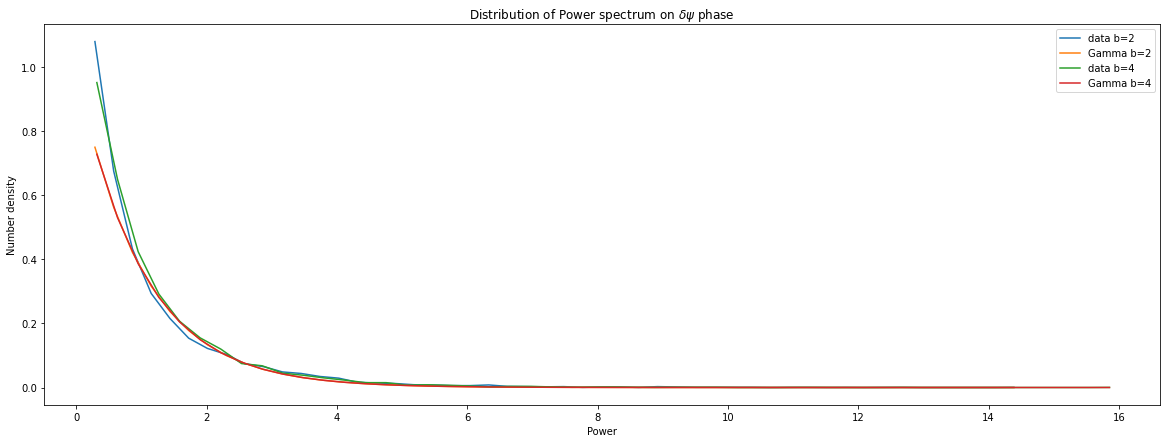

In [385]:
i=50
j=99

data,x=np.histogram(Anomalies_spectra[:,i,j]/scale_estimates[i,j],bins=50,density=True)
data_4,x_4=np.histogram(Anomalies_spectra_4[:,i,j]/scale_estimates_4[i,j],bins=50,density=True)

norm_data=data/sc.special.gamma(Spectral_dof[i,j]/2)
norm_data_4=data_4/sc.special.gamma(Spectral_dof[i,j]/2)

m=sc.stats.gamma.pdf(x[1:],a=Spectral_dof[i,j]/2,loc=0,scale=1)
l=sc.stats.gamma.pdf(x_4[1:],a=Spectral_dof[i,j]/2,loc=0,scale=1)

plt.figure(figsize=(20,7))

plt.plot(x[1:],norm_data,label='data b=2')
plt.plot(x[1:],m,label='Gamma b=2')
plt.plot(x_4[1:],norm_data_4,label='data b=4')
plt.plot(x_4[1:],l,label='Gamma b=4')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

# Distribution of total power 

In [458]:
i=1
j=10
print(spectra[0,i,j])
print(spectra[0,i,-j])

(0.0025920129813930036-0.002353340178907438j)
(0.002592012981393003+0.002353340178907439j)


In [416]:
spectra[0,10,10]

(-0.008335256777752409-0.003931552987359843j)

In [417]:
spectra[0,-10,-10]

(-0.0057371824958188395-0.019875603504104056j)

In [520]:
power=(Anomalies_spectra[:,:,:50]/scale_estimates[:,:50]).sum(axis=(1,2))
power_4=(Anomalies_spectra_4[:,:,:50]/scale_estimates_4[:,:50]).sum(axis=(1,2))

power_wrong=(Anomalies_spectra[:,:,:50]/scale_estimates_4[:,:50]).sum(axis=(1,2))


In [462]:
total_dof=(Spectral_dof[:,:51]/2).sum()

In [463]:
total_dof

5000.0

In [402]:
data.max()

0.0008620218787288558

In [435]:
power.mean()

10000.0

In [481]:
power_4[1862]

6029.761936050524

In [482]:
power_4[1863]

9430.678165514302

In [485]:
Anomalies_spectra_4[1863].sum()

308.55139278281837

In [486]:
Anomalies_spectra_4[1862].sum()

252.6993407875669

In [489]:
(np.abs(np.fft.fft(Anomalies_images_4[1863]))**2).sum()

308.55139278281837

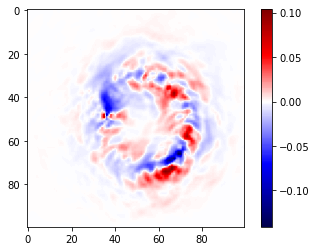

In [512]:
plt.imshow(Anomalies_images_4[1864],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

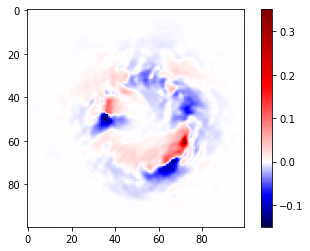

In [513]:
plt.imshow(Anomalies_images_4[1863],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

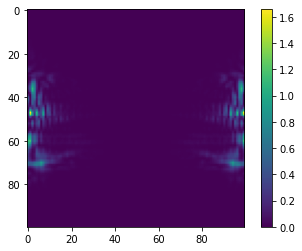

In [483]:
plt.imshow(Anomalies_spectra_4[1862])
plt.colorbar()

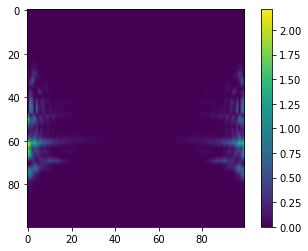

In [484]:
plt.imshow(Anomalies_spectra_4[1863])
plt.colorbar()

In [478]:
np.where(power_4==power_4.max())

(array([1863]),)

In [474]:
data

array([8.33948341e-06, 5.88976016e-05, 2.05880997e-04, 4.62841329e-04,
       6.87486163e-04, 7.93293359e-04, 7.54723248e-04, 6.67679890e-04,
       4.96199263e-04, 3.79967713e-04, 2.45493543e-04, 1.60535056e-04,
       1.11540591e-04, 6.46309964e-05, 4.89944650e-05, 2.29335794e-05,
       1.40728783e-05, 8.86070112e-06, 5.21217713e-06, 3.12730628e-06,
       3.64852399e-06, 2.08487085e-06, 1.56365314e-06, 5.21217713e-07,
       5.21217713e-07, 5.21217713e-07, 5.21217713e-07, 1.04243543e-06,
       5.21217713e-07, 5.21217713e-07])

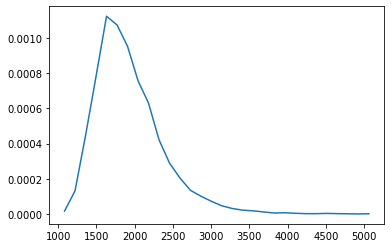

In [515]:
data,x=np.histogram(power_wrong,bins=30,density=True)
plt.plot(x[1:],data,label='data b=2')

In [528]:
power.mean()/11

454.54545454545456

In [526]:
power.std()**2/power.mean()

11.242665399392349

In [568]:
power.mean()

5000.0

In [567]:
power_wrong.mean()

72595.0717640772

In [564]:
power_wrong=(Anomalies_spectra[:,:,:50]/scale_estimates_4[:,:50]).sum(axis=(1,2))

In [570]:
power_wrong.std()

3865.826611479287

In [571]:
power.std()

237.09349842828198

Text(0, 0.5, 'Number density')

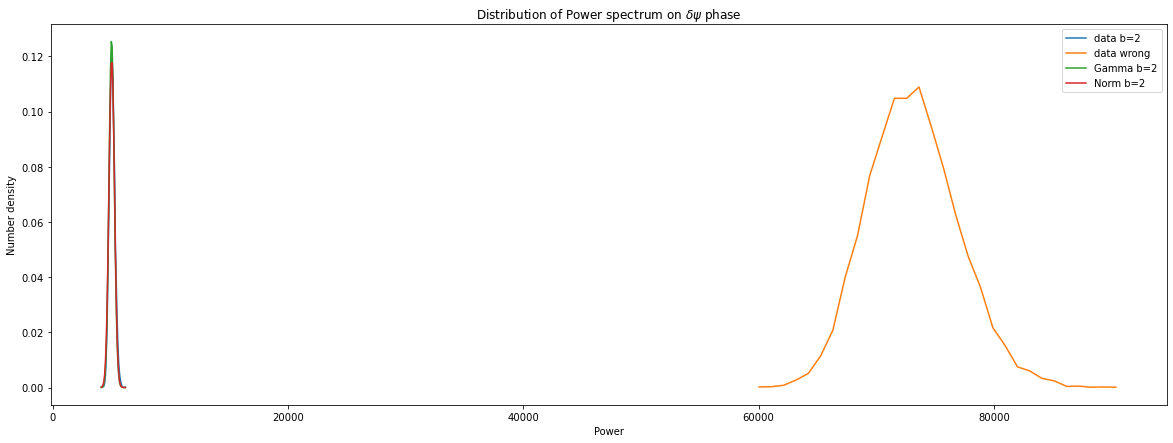

In [569]:
data,x=np.histogram(power,bins=30,density=True)
data_4,x_4=np.histogram(power_wrong,bins=30,density=True)

norm_data=data/data.sum()
norm_data_4=data_4/data_4.sum()

k=500

m=sc.stats.gamma.pdf(x[1:],a=k,loc=0,scale=power.mean()/k)
n=sc.stats.norm.pdf(x[1:],loc=power.mean(),scale=power.std())


plt.figure(figsize=(20,7))

plt.plot(x[1:],norm_data,label='data b=2')
plt.plot(x_4[1:],norm_data_4,label='data wrong')
plt.plot(x[1:],m/m.sum(),label='Gamma b=2')
plt.plot(x[1:],n/n.sum(),label='Norm b=2')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

Text(0, 0.5, 'Number density')

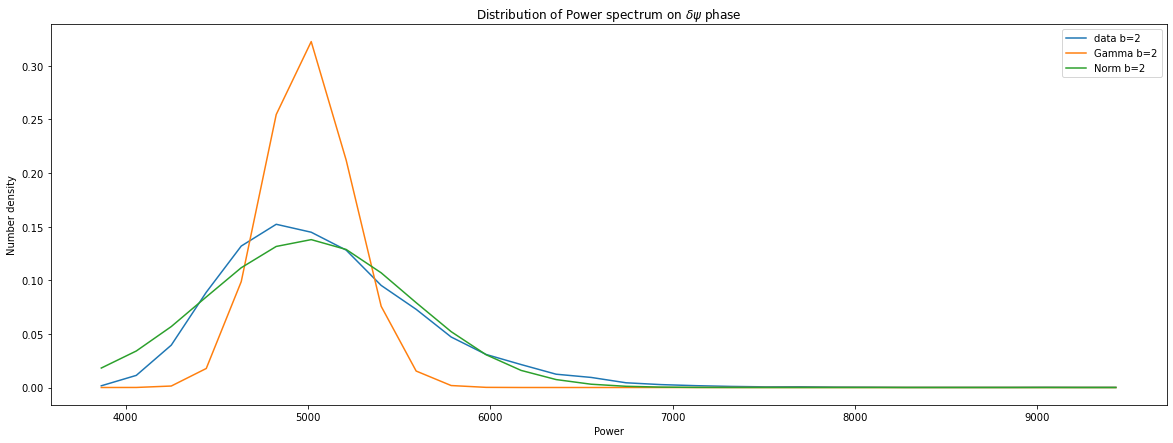

In [550]:
data,x=np.histogram(power,bins=30,density=True)
data_4,x_4=np.histogram(power_4,bins=30,density=True)

norm_data=data/data.sum()
norm_data_4=data_4/data_4.sum()

k=450

m=sc.stats.gamma.pdf(x_4[1:],a=k,loc=0,scale=power_4.mean()/k)
n=sc.stats.norm.pdf(x_4[1:],loc=power_4.mean(),scale=power_4.std())


plt.figure(figsize=(20,7))

plt.plot(x_4[1:],norm_data_4,label='data b=2')
plt.plot(x_4[1:],m/m.sum(),label='Gamma b=2')
plt.plot(x_4[1:],n/n.sum(),label='Norm b=2')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

In [551]:
power_4_corrected=deepcopy(power_4)
power_4_corrected=power_4_corrected[power_4<7000]

Text(0, 0.5, 'Number density')

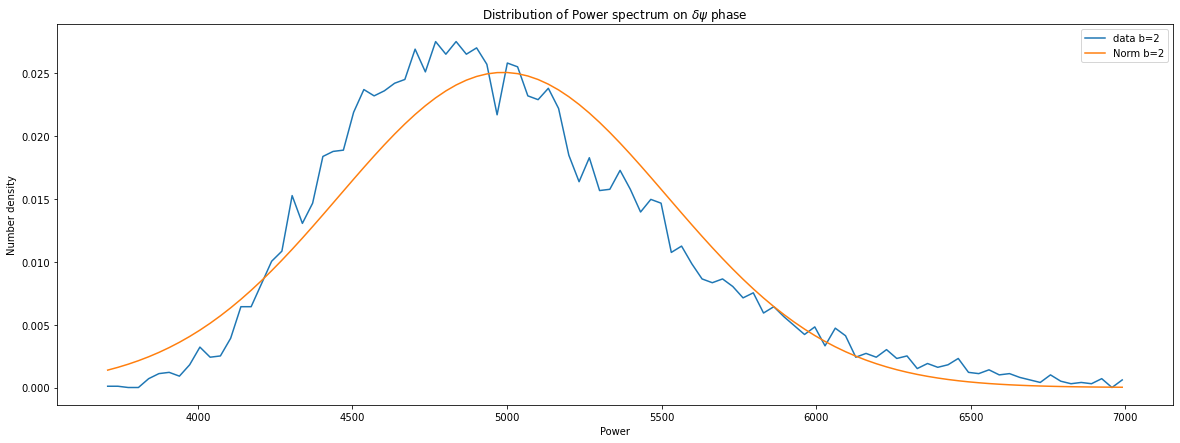

In [554]:
data_4,x_4=np.histogram(power_4_corrected,bins=100,density=True)

norm_data=data/data.sum()
norm_data_4=data_4/data_4.sum()
plt.figure(figsize=(20,7))


n=sc.stats.norm.pdf(x_4[1:],loc=power_4_corrected.mean(),scale=power_4_corrected.std())


plt.plot(x_4[1:],norm_data_4,label='data b=2')
plt.plot(x_4[1:],n/n.sum(),label='Norm b=2')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

In [555]:
power_4_corrected.std()

531.3145034185566

In [556]:
power_4_corrected.mean()

4987.082699999181

In [560]:
power.mean()

5000.0

In [561]:
power.std()

237.09349842828198

In [222]:
distribution = "gamma"
distr = getattr(sc.stats, distribution)
params = distr.fit(data,fa=0.5)

In [223]:
params

(0.5, -7.107590319422856e-30, 0.7877577151108912)

In [231]:
m.sum()

0.9069371699797725

In [232]:
data.sum()

1.9882101378656936

In [174]:
Spectral_dof[i,j]/2

0.5

In [144]:
Spectral_dof[i,j]/2

0.5

1.7724538509055159

In [69]:
q=deepcopy(Anomalies_spectra[:,i,j]/scale_estimates[i,j])

In [70]:
q.mean()

1.0000000000000022

In [53]:
data,x=np.histogram(Anomalies_spectra[:,i,j]/scale_estimates[i,j],bins=30)


In [56]:
m.sum()

90.52883647319571

In [57]:
l.sum()

396.7791173100376

In [43]:
data.sum()

10000

In [44]:
m.sum()

2.509171877605574

In [45]:
l.sum()

1.4318387167610396

In [46]:
data_4.sum()

10000

In [40]:
params

(1, -3.4250623966261483e-11, 333.33333134038435)

In [41]:
params_4

(1, -2.1603394675270227e-11, 333.33332069310654)